## Kaggle Titanic Competition

##### Submitted by: Soumik Ghosh



In [89]:
import pandas as pd
import numpy as np
import random as rnd
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


We are reading the data into train_df and test_df from the .csv files.

In [90]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [91]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [92]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### **Data Preprocessing**

Let us see the how the different numerical features are related to each other.

In [93]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We will drop **Ticket** feature from train data because **Ticket** is a Nominal Data.

In [94]:
train_df.drop(columns=['PassengerId', 'Ticket'], inplace=True)
test_df.drop(columns=["Ticket"], inplace=True)

We will check for the percentage of missing values.

In [95]:
train_df.isna().sum()/len(train_df)

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

We observe that more than 70% **Cabin** values are NULL. So, we will check how the **Cabin** values affect the survival rate.

In [96]:
print(f'Survival rate of people with no Cabin value: {train_df[train_df.Cabin.isnull()].Survived.mean():.2f}')
print(f'Survival rate of people with a Cabin value: {train_df[train_df.Cabin.notnull()].Survived.mean():.2f}')

Survival rate of people with no Cabin value: 0.30
Survival rate of people with a Cabin value: 0.67


Since we see here that the people with no **Cabin** value had a survical rate of 30% and the people with a **Cabin** value had a survival rate of 67%, we assume that people who had a **Cabin** had higher chances of survival.

So, we extract the first letter of the occupied **Cabin** values and put them in a feature called **Deck**. We also set the **NULL** values of **Cabin** to 'U'. 

In [97]:
data = [train_df, test_df]
deck = {"A": "A", "B": "B", "C": "C", "D": "D", "E": "E", "F": "F", "G": "G", "U": "U"}

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna("U")
    
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [98]:
train_df['Deck'].value_counts()

U    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Deck, dtype: int64

In [99]:
test_df['Deck'].value_counts()

U    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Deck, dtype: int64

In [100]:
train_df.groupby('Deck').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Deck,,,,,,
A,0.466667,1.000000,44.833333,0.133333,0.133333,39.623887
B,0.744681,1.000000,34.955556,0.361702,0.574468,113.505764
C,0.593220,1.000000,36.086667,0.644068,0.474576,100.151341
D,0.757576,1.121212,39.032258,0.424242,0.303030,57.244576
E,0.750000,1.312500,38.116667,0.312500,0.312500,46.026694
F,0.615385,2.384615,19.954545,0.538462,0.538462,18.696792
G,0.500000,3.000000,14.750000,0.500000,1.250000,13.581250
U,0.299419,2.636628,27.588208,0.546512,0.364826,19.181079


We will convert **Sex** feature to binary feature.

In [101]:
train_df.Sex.replace({'male':0,'female':1}, inplace=True)
test_df.Sex.replace({'male':0,'female':1}, inplace=True)

There are two more features with NULL values: **Embarked** and **Age**.

Let us deal with **Embarked**, first. We will be replacing the NULL values with the most appearing embark value, i.e, the **mode**.

In [102]:
train_df.Embarked = train_df.Embarked.fillna(train_df.Embarked.mode()[0])
test_df.Embarked = test_df.Embarked.fillna(train_df.Embarked.mode()[0])
train_df.Embarked.value_counts(dropna=False)

S    646
C    168
Q     77
Name: Embarked, dtype: int64

For **Age** missing values, we used KNN Imputer. We will consider the numerical features for KNN imputer to work.

In [103]:
numerical_feat_names = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
imp = KNNImputer(n_neighbors=4)
imp.fit(train_df[numerical_feat_names])

KNNImputer(n_neighbors=4)

In [104]:
# Transform train train_df
train_df[numerical_feat_names] = imp.transform(train_df[numerical_feat_names])
# Transform the test train_df
test_df[numerical_feat_names] = imp.transform(test_df[numerical_feat_names])


**We verify below that there are no NULL values left.**

In [105]:
train_df.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Deck        0
dtype: int64

Let us now look at the names. We can extract the Titles from the names to see if it is related to the survival.

In [106]:
train_df['Title'] = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_df.Title.value_counts(normalize=True)

Mr          0.580247
Miss        0.204265
Mrs         0.140292
Master      0.044893
Dr          0.007856
Rev         0.006734
Mlle        0.002245
Major       0.002245
Col         0.002245
Countess    0.001122
Capt        0.001122
Ms          0.001122
Sir         0.001122
Lady        0.001122
Mme         0.001122
Don         0.001122
Jonkheer    0.001122
Name: Title, dtype: float64

Titles 'Mr', 'Miss', 'Mrs', and 'Master' occur in more than 1% of the train data. 

We will replace rest of the titles with 'Rare' keyword or more common title.

In [107]:
train_df.loc[~train_df.Title.isin(['Miss', 'Mrs', 'Mr', 'Master']), 'Title'] = 'Rare'
test_df.loc[~test_df.Title.isin(['Miss', 'Mrs', 'Mr', 'Master']), 'Title'] = 'Rare'

In [108]:
train_df.Title.value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64

In [109]:
test_df.Title.value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rare        7
Name: Title, dtype: int64

We will use title in our analysis/modeling. We can also drop the Name feature.

In [110]:
train_df.drop(columns='Name', inplace=True)
test_df.drop(columns='Name', inplace=True)

 **Visualizations**

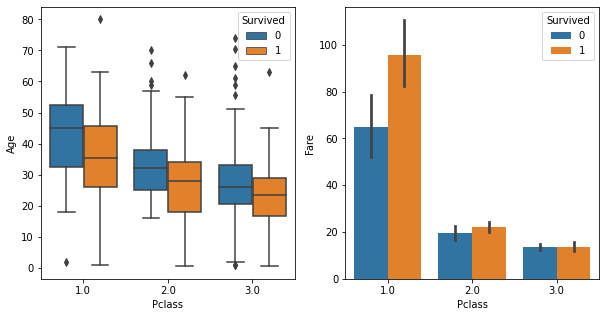

In [111]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.boxplot(hue='Survived', x='Pclass', y='Age', data=train_df, ax=ax[0])
sns.barplot(hue='Survived', x='Pclass', y='Fare', data=train_df, ax=ax[1])
plt.show()

We see here that younger people have survived more than the older ones across all the 3 Pclasses.
Also, we can see that people who have paid more fare in the PClass 1 and PClass 2 have survived more.

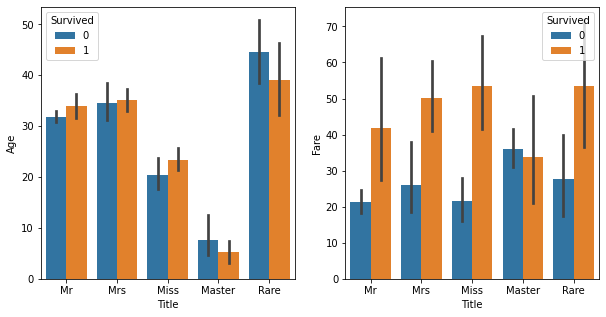

In [112]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.barplot(hue='Survived', x='Title', y='Age', data=train_df, ax=ax[0])
sns.barplot(hue='Survived', x='Title', y='Fare', data=train_df, ax=ax[1])
plt.show()

We can see here how age and fare are related to survival for different titles.

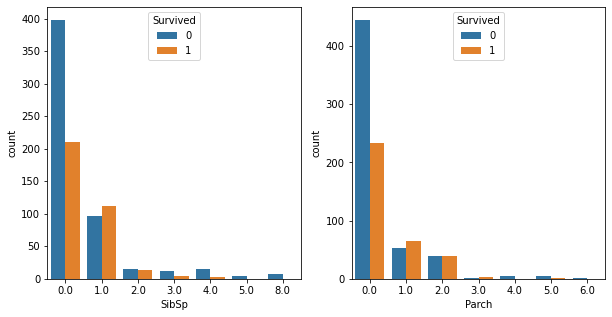

In [113]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.countplot(x='SibSp', hue='Survived', data=train_df, ax=ax[0])
sns.countplot(x='Parch', hue='Survived', data=train_df, ax=ax[1])
plt.show()

We can see here that people who were alone had much less chances of survival.

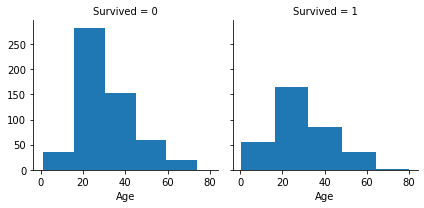

In [114]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=5)
plt.show()

We can see here that younger people survived more than older people.

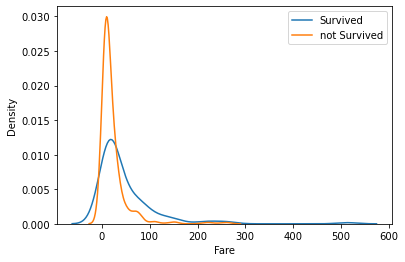

In [115]:
sns.kdeplot(train_df[train_df.Survived==1].Fare)
sns.kdeplot(train_df[train_df.Survived==0].Fare)
plt.legend(['Survived', 'not Survived'])
plt.show()

We can see here again that people who paid less fare has much less chances of survival.

#### **Feature Engineering**

We will define a feature as Family Size, where,
Family Size = Number of Siblings and Spouse + Number of Parents and Children + 1
If Famly size = 1, we define a new feature, called IsAlone. 

In [116]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4.0,0.724138
2,3.0,0.578431
1,2.0,0.552795
6,7.0,0.333333
0,1.0,0.303538
4,5.0,0.200000
5,6.0,0.136364
7,8.0,0.000000
8,11.0,0.000000


In [117]:
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [118]:
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['IsAlone'] = 0
test_df.loc[test_df['FamilySize'] == 1, 'IsAlone'] = 1

Since the Embarked feature cannot be changed to Ordinal Data, we will expand it to three columns, namely EmbarkedC, EmbarkedQ and EmbarkedS using One-Hot Ecoding from Pandas.

In [119]:
pd.get_dummies(train_df.Embarked)

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


In [120]:
train_df[['EmbarkedC', 'EmbarkedQ', 'EmbarkedS']] = pd.get_dummies(train_df.Embarked)

In [121]:
test_df[['EmbarkedC', 'EmbarkedQ', 'EmbarkedS']] = pd.get_dummies(test_df.Embarked)

In [122]:
train_df.drop(columns='Embarked', inplace=True)

In [123]:
test_df.drop(columns='Embarked', inplace=True)

Similarly, we do One-Hot Encoding for Title as well.

In [124]:
pd.get_dummies(train_df.Title)

,Master,Miss,Mr,Mrs,Rare
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,1,0,0
...,...,...,...,...,...
886,0,0,0,0,1
887,0,1,0,0,0
888,0,1,0,0,0
889,0,0,1,0,0


In [125]:
train_df[['Master', 'Ms', 'Mr', 'Mrs', 'Rare']] = pd.get_dummies(train_df.Title)

In [126]:
test_df[['Master', 'Ms', 'Mr', 'Mrs', 'Rare']] = pd.get_dummies(test_df.Title)

In [127]:
train_df.drop(columns='Title', inplace=True)

In [128]:
test_df.drop(columns='Title', inplace=True)

Finally we do one-hot encoding for the **Deck** values and split it up into Diferrent Cabin prefix columns and then drop the Deck feature.

In [129]:
train_df[['CabinA', 'CabinB', 'CabinC', 'CabinD', 'CabinE', 'CabinF', 'CabinG', 'CabinU']] = pd.get_dummies(train_df.Deck)
test_df[['CabinA', 'CabinB', 'CabinC', 'CabinD', 'CabinE', 'CabinF', 'CabinG', 'CabinU']] = pd.get_dummies(test_df.Deck)

In [130]:
train_df.drop(columns='Deck', inplace=True)
test_df.drop(columns='Deck', inplace=True)

Now the preprocessing is done. Let us check our final dataframe.

In [131]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    float64
 2   Sex         891 non-null    float64
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    float64
 5   Parch       891 non-null    float64
 6   Fare        891 non-null    float64
 7   FamilySize  891 non-null    float64
 8   IsAlone     891 non-null    int64  
 9   EmbarkedC   891 non-null    uint8  
 10  EmbarkedQ   891 non-null    uint8  
 11  EmbarkedS   891 non-null    uint8  
 12  Master      891 non-null    uint8  
 13  Ms          891 non-null    uint8  
 14  Mr          891 non-null    uint8  
 15  Mrs         891 non-null    uint8  
 16  Rare        891 non-null    uint8  
 17  CabinA      891 non-null    uint8  
 18  CabinB      891 non-null    uint8  
 19  CabinC      891 non-null    u

We see the correlation heatmap between the different features below.

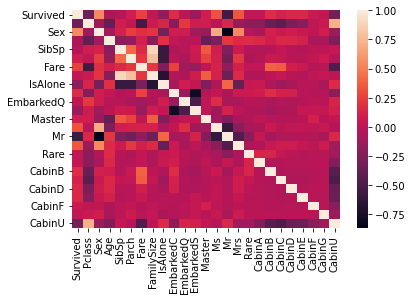

In [132]:
sns.heatmap(train_df.corr())
plt.show()

In [133]:
X_train = train_df.drop("Survived", axis=1)
X_test  = test_df.drop("PassengerId", axis=1).copy()

Y_train = train_df["Survived"]

We scale the data to values between 0 and 1. 

In [134]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### **Fitting different models**

In [135]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_LR = logreg.predict(X_test)
accuracy_log = round(logreg.score(X_train, Y_train) * 100, 2)
accuracy_log

84.29

In [136]:
# model = KNeighborsClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# space = {'n_neighbors': [3, 5, 10, 15, 25],
#  'weights': ['uniform', 'distance'],
#  'algorithm': ['ball_tree', 'kd_tree', 'brute'],
#  'leaf_size': [10, 20, 30, 40, 50, 60],
#  'p': [1, 2, 3, 4, 5],
#  'metric': ['minkowski']}
# search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# result = search.fit(X_train, Y_train)
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

In [137]:
# knn = KNeighborsClassifier(weights='uniform', p=1, n_neighbors=10, metric='minkowski', leaf_size=20, algorithm='brute' )
# knn.fit(X_train, Y_train)
# Y_pred_KNN = knn.predict(X_test)
# accuracy_knn = round(knn.score(X_train, Y_train) * 100, 2)
# accuracy_knn

The hyper parameter testing does not improve the prediction, so I used **vanilla KNN**.

In [138]:
#K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, Y_train)
Y_pred_KNN = knn.predict(X_test)
accuracy_knn = round(knn.score(X_train, Y_train) * 100, 2)
accuracy_knn

83.61

In [139]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_RF = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
accuracy_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
accuracy_random_forest

98.65

In [140]:
#XGBoost

xgb = XGBClassifier(use_label_encoder=False, random_state = 42)
xgb.fit(X_train, Y_train, eval_metric='rmse')
Y_pred_xgb = xgb.predict(X_test)
xgb.score(X_train, Y_train)
accuracy_xgb = round(xgb.score(X_train, Y_train) * 100, 2)
accuracy_xgb

93.94

In [141]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred_SVC = svc.predict(X_test)
accuracy_svm = round(svc.score(X_train, Y_train) * 100, 2)
accuracy_svm

84.29

In [142]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_NB = gaussian.predict(X_test)
accuracy_NB = round(gaussian.score(X_train, Y_train) * 100, 2)
accuracy_NB

79.24

In [143]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred_P = perceptron.predict(X_test)
accuracy_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
accuracy_perceptron

78.68

In [144]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred_SVC = linear_svc.predict(X_test)
accuracy_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
accuracy_linear_svc

83.5

In [145]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred_SGD = sgd.predict(X_test)
accuracy_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
accuracy_sgd

80.36

In [146]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_DT = decision_tree.predict(X_test)
accuracy_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
accuracy_decision_tree

98.65

**We will now tabulate all our model accuracies below.**

In [147]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'XGBoost', 'Support Vector Machines', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [accuracy_knn, accuracy_log, 
              accuracy_random_forest, accuracy_xgb, accuracy_svm, accuracy_NB, accuracy_perceptron, accuracy_sgd, 
              accuracy_linear_svc, accuracy_decision_tree ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,98.65
9,Decision Tree,98.65
3,XGBoost,93.94
1,Logistic Regression,84.29
4,Support Vector Machines,84.29
0,KNN,83.61
8,Linear SVC,83.50
7,Stochastic Gradient Decent,80.36
5,Naive Bayes,79.24
6,Perceptron,78.68


After submitting the results for the 10 models, I get the maximum accuracy for KNN which is reported as **0.79665** by Kaggle. 

I had used used Hyper Parameter testing for Logistic Regression, KNN and Random Forest, but the accuracy is not improving. 

The **Random Forest** gives us the most accuracy here, but while comparing it with the Kaggle Test Dataset it is not giving us a better accuracy because of overfitting.

In [149]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred_xgb
    })
submission.to_csv('submission.csv', index=False)